In [1]:
from azure.identity import DefaultAzureCredential, InteractiveBrowserCredential, AzureCliCredential
from azure.ai.ml import MLClient, Input
from azure.ai.ml.constants import AssetTypes, InputOutputModes
import mlflow

In [2]:
try:
    credential = DefaultAzureCredential()
    # Check if given credential can get token successfully.
    credential.get_token("https://management.azure.com/.default")
except Exception as ex:
    # Fall back to InteractiveBrowserCredential in case DefaultAzureCredential not work
    # This will open a browser page for
    credential = InteractiveBrowserCredential()

In [3]:
config_path = './.azureml/config.json'
ml_client = MLClient.from_config(credential=credential, config_path=config_path)


# Se configura tracking url ya que se está corriendo localmente, en azure compute es configurado automáticamente
azureml_mlflow_uri = ml_client.workspaces.get(ml_client.workspace_name).mlflow_tracking_uri
mlflow.set_tracking_uri(azureml_mlflow_uri)

Found the config file in: .\.azureml\config.json


In [4]:
import warnings

warnings.simplefilter("ignore")

In [5]:
mlflow.set_experiment(experiment_name="diabetes-classifier")

<Experiment: artifact_location='', creation_time=1691593465421, experiment_id='76c9f370-f632-4a55-aaa2-2471b4bb5820', last_update_time=None, lifecycle_stage='active', name='diabetes-classifier', tags={}>

In [6]:
import pandas as pd

file_url = "data"

data_info = ml_client.data.get(name="input-diabetes-data", version=1)

In [7]:
import azure.ai.ml._artifacts._artifact_utilities as artifact_utils
# Download the dataset
artifact_utils.download_artifact_from_aml_uri(uri = data_info.path, destination = file_url, datastore_operation=ml_client.datastores)
file_url = file_url + "/data.csv"

In [8]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

class DataCleaning:
    #Inicializamos cargando la data
    def __init__(self, data_path = None, data_set = None ) -> None:
        if data_set is None:
            self.data_path = data_path
            self.dataframe = pd.read_csv(data_path, delimiter=";")
        else: 
            self.dataframe = data_set

    #Creamos un método para manejar los valores que estén nulos
    def handle_missing_values(self):
        self.dataframe = self.dataframe.dropna() #Método para eliminar las filas con valores faltantes de (ojo!! pueden interpolarse o rellenarse)

    #Creamos un método para manejar variables que no son numéricas
    def handle_categorical_features(self):
        df_copy = self.dataframe.copy()

        for col in df_copy.columns:
            if df_copy[col].dtype == object:
                le = LabelEncoder()

                df_copy[col] = le.fit_transform(df_copy[col])

        self.dataframe =  df_copy
    
    #Creamos un método para manejar la clase objetivo de manera desbalanceada (si lo está)
    def handle_imbalanced_data(self, objetive):
        pass

    #Creamos un método para escalar las caracteristicas que queramos
    def scalate_features(self, feature):
        pass

    #Creamos un método para identificar y eliminar caracteristicas que sean irrelevantes
    def remove_irrelevant_features(self):
        pass

    #Creamos un método para obtener X y y test, para evaluación de performance
    def performance_split(self, target_feature):
        self.X_test_performance = self.dataframe.drop(columns=[target_feature])
        self.y_test_performance = self.dataframe[target_feature]
    
    #Creamos un método para realizar el split de la data
    def split_data(self, target_feature, size):
        X = self.dataframe.drop(columns=[target_feature])
        y = self.dataframe[target_feature]

        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(X, y, test_size=size, random_state=42)

In [9]:
data_clean = DataCleaning(data_path = file_url)
data_clean.handle_missing_values()
data_clean.handle_categorical_features()
data_clean.split_data("Diabetes", 0.2)

In [10]:
mlflow.xgboost.autolog()

In [11]:
from xgboost import XGBClassifier

model = XGBClassifier(eval_metric="logloss", gamma = 1, max_depth = 10, n_estimators= 200)

In [12]:
run = mlflow.start_run()

In [13]:
model.fit(data_clean.X_train, data_clean.y_train, eval_set=[(data_clean.X_test, data_clean.y_test)], verbose=False)

2023/08/09 14:27:14 WARNING mlflow.xgboost: Failed to log dataset information to MLflow Tracking. Reason: The following failures occurred while performing one or more logging operations: [MlflowException('Failed to perform one or more operations on the run with ID 4a0806fc-93dc-44e0-ba51-cd51f0109962. Failed operations: [MlflowException("API request to endpoint /api/2.0/mlflow/runs/log-inputs failed with error code 404 != 200. Response body: \'\'")]')]


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=1, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=10,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=200, n_jobs=None,
              num_parallel_tree=None, predictor=None, random_state=None, ...)

In [14]:
y_pred = model.predict(data_clean.X_test)

from sklearn.metrics import accuracy_score, recall_score

accuracy = accuracy_score(data_clean.y_test, y_pred)
recall = recall_score(data_clean.y_test, y_pred)

2023/08/09 14:27:37 WARNING mlflow.sklearn: Failed to log evaluation dataset information to MLflow Tracking. Reason: API request to endpoint /api/2.0/mlflow/runs/log-inputs failed with error code 404 != 200. Response body: ''
2023/08/09 14:27:40 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during xgboost autologging: UserError: Resource Conflict: ArtifactId ExperimentRun/dcid.4a0806fc-93dc-44e0-ba51-cd51f0109962/metric_info.json already exists.


In [15]:
print("Accuracy: %.2f%%" % (accuracy * 100.0))
print("Recall: %.2f%%" % (recall * 100.0))

Accuracy: 72.67%
Recall: 70.26%


In [16]:
mlflow.end_run()

In [17]:
run = mlflow.get_run(run.info.run_id)

In [18]:
pd.DataFrame(data=[run.data.params], index=["Value"]).T

,Value
objective,binary:logistic
base_score,None
booster,None
colsample_bylevel,None
colsample_bynode,None
colsample_bytree,None
eval_metric,logloss
gamma,1
gpu_id,None
grow_policy,None


In [19]:
pd.DataFrame(data=[run.data.metrics], index=["Value"]).T

,Value
validation_0-logloss,0.576312
accuracy_score_unknown_dataset,0.726713
recall_score_unknown_dataset,0.702592


In [20]:
client = mlflow.tracking.MlflowClient()
client.list_artifacts(run_id=run.info.run_id)

[<FileInfo: file_size=-1, is_dir=False, path='feature_importance_weight.json'>,
 <FileInfo: file_size=-1, is_dir=False, path='feature_importance_weight.png'>,
 <FileInfo: file_size=-1, is_dir=False, path='metric_info.json'>,
 <FileInfo: file_size=-1, is_dir=True, path='model'>]

In [21]:
file_path = mlflow.artifacts.download_artifacts(
    run_id=run.info.run_id, artifact_path="feature_importance_weight.png"
)

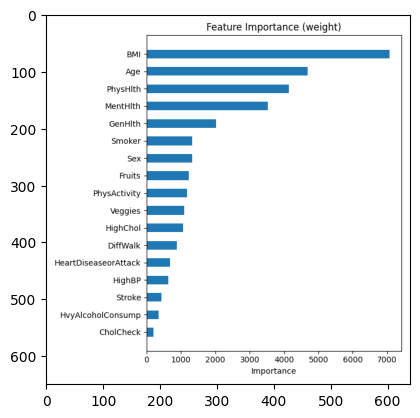

In [22]:
import matplotlib.pyplot as plt
import matplotlib.image as img

image = img.imread(file_path)
plt.imshow(image)
plt.show()

In [23]:
classifier = mlflow.xgboost.load_model(f"runs:/{run.info.run_id}/model")

In [24]:
type(classifier)

xgboost.sklearn.XGBClassifier

In [25]:
classifier.predict(data_clean.X_test)

array([1, 1, 1, ..., 1, 0, 1])